# Delivery Time Prediction

Delivery time prediction has long been a part of city logistics, but refining accuracy has recently become very important for services which deliver food on-demand.

These services and similar ones must receive an order and have it delivered within minutes to appease their users. In these situations a few minutes can make a big difference so it’s very important for customer satisfaction that the initial prediction is highly accurate and that any delays are communicated effectively.

In this project, I’ll discuss my experience building a real-world delivery time prediction model. I'll get into technical topics of machine learning while focusing on the business knowledge required to create a well-functioning predictive model.

**Let's go!**

![delivery](images/delivery.jpg)

## Content Table

- [1 Script Configurations](#1-Script-Configurations)
- [2 Exploring the Dataset](#2-Exploring-the-Dataset)
    - [2.1 Orders](#2.1-Orders)
    - [2.2 Order Products](#2.2-Order-Products)
    - [2.3 Shoppers](#2.3-Shoppers)
    - [2.4 Stores](#2.4-Stores)
- [3 Data Manipulation](#3-Data-Manipulation)
- [4 Predictive Modeling](#4-Predictive-Modeling)
    - [4.1 Evaluation Metrics](#4.1-Evaluation-Metrics)
    - [4.2 Introducing Lasso](#4.2-Introducing-Lasso)
    - [4.3 Polynomial Features](#4.3-Polynomial-Features)
    - [4.4 Feature Engineering](#4.4-Feature-Engineering)
    - [4.5 Tackling Outliers](#4.5-Tackling-Outliers)
    - [4.6 Colinearity](#4.6-Colinearity)
    - [4.7 Results](#4.7-Results)
- [5 Conclusions](#5-Conclusions)

## 1 Script Configurations

In this first section, we are going to import the Python modules used throughout this project, as well as define some global configurations.

In [1]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from scipy.stats import iqr, shapiro, ttest_ind
from sklearn.linear_model import Lasso
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from skopt import BayesSearchCV

In [2]:
# Configurations
np.random.seed(1)
warnings.filterwarnings('ignore')

In [3]:
# Global variables
DATASETS_PATH = 'datasets'

## 2 Exploring the Dataset

Before jumping into machine learning, let's have a look at the data and see what insights we can obtain.

### 2.1 Orders

The first dataset is a list that contains the details of every order.

In [4]:
# Load the dataset
orders = pd.read_csv(f'{DATASETS_PATH}/orders.csv')
orders.head()

,order_id,lat,lng,promised_time,on_demand,shopper_id,store_branch_id,total_minutes
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822


In [5]:
# Dataset shape
print(f'orders shape: {orders.shape}')

orders shape: (10000, 8)


In [6]:
# Features and types
orders.dtypes

order_id            object
lat                float64
lng                float64
promised_time       object
on_demand             bool
shopper_id          object
store_branch_id     object
total_minutes      float64
dtype: object

In [7]:
# Check for missing or null values in order_products
print(f'number of missing values: {orders.isna().sum().sum()}')

number of missing values: 2000


In [8]:
# Locating the missing values
orders.isna().sum()

order_id              0
lat                   0
lng                   0
promised_time         0
on_demand             0
shopper_id            0
store_branch_id       0
total_minutes      2000
dtype: int64

In [9]:
# Dataset statistics
orders.describe()

,lat,lng,total_minutes
count,10000.000000,10000.000000,8000.000000
mean,-33.427090,-70.668017,81.106130
std,0.558675,0.400249,34.720837
min,-36.942135,-73.144280,11.969489
25%,-33.426861,-70.605795,55.225480
50%,-33.398110,-70.574591,74.731672
75%,-33.353783,-70.540307,100.273498
max,-29.833517,-70.453728,304.190303


In [10]:
# Number of unique values
orders.nunique()

order_id           10000
lat                 8241
lng                 8193
promised_time        888
on_demand              2
shopper_id          2864
store_branch_id      476
total_minutes       8000
dtype: int64

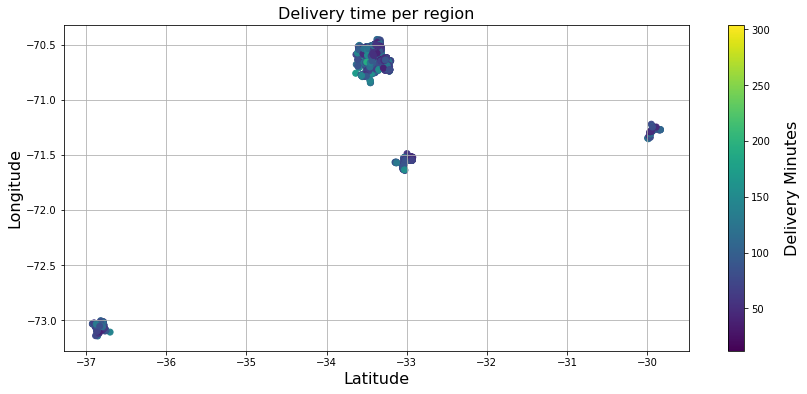

In [11]:
# Delivery time per region
orders_temp = orders.copy()
orders_temp = orders_temp.dropna()

plt.figure(figsize=(14, 6))
plt.scatter(orders_temp['lat'], orders_temp['lng'], c=orders_temp['total_minutes'])
color_bar = plt.colorbar()
color_bar.set_label('Delivery Minutes', labelpad=15, size=16)
plt.grid()
plt.xlabel('Latitude', size=16)
plt.ylabel('Longitude', size=16)
plt.title('Delivery time per region', size=16)
plt.show()

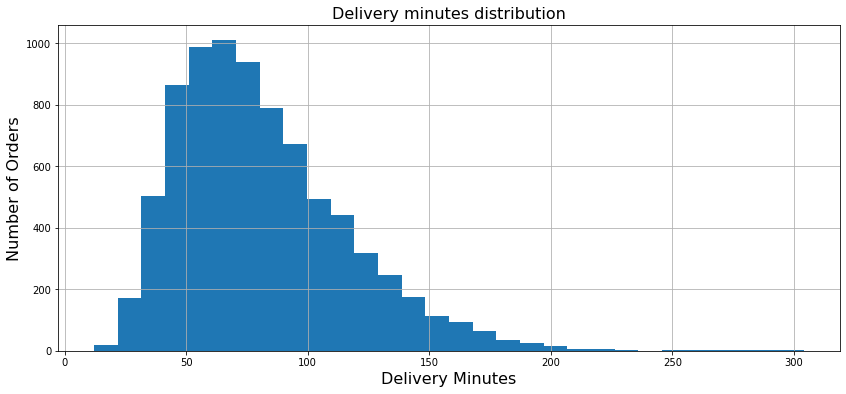

In [12]:
# Total minutes distribution
_, ax = plt.subplots(figsize=(14, 6))
orders.hist('total_minutes', bins=30, ax=ax)
plt.xlabel('Delivery Minutes', size=16)
plt.ylabel('Number of Orders', size=16)
plt.title('Delivery minutes distribution', size=16)
plt.show()

**Observations:**
- *order_id*, *shopper_id* and *store_branch_id* don't contribute to our problem, except for joining datasets
- *promised_time* can be used to identify the period of the delivery (example: morning, afternoon, evening)
- don't know exactly how *on_demand* affect the delivery time, maybe the shopper goes faster when the order was promised
- 2000 orders don't have *total_minutes* as they are part of the submission answers
- 75% of the deliveries have a *total_minutes* below 100, but we can see that we have some outliers with up to 300 minutes
- *total_minutes* distribution is right skewed

### 2.2 Order Products

Next we have a dataset containing the list of products of each order.

In [13]:
# Load the dataset
order_products = pd.read_csv(f'{DATASETS_PATH}/order_products.csv')
order_products.head()

,order_id,product_id,quantity,buy_unit
0,47099653730fb1b76537fc10ad876255,c1244453d731c77416cb4766e3bd76cb,1.0,UN
1,689d8866915acf87e851c2591a23a82f,43cc2b100bec640fe563cd16f2db669f,1.0,KG
2,f26d16bf6f38c9e31d0be877f4013a9e,b8f880759d014134e272d881d49989a2,1.0,UN
3,161ccc896835ab41761b0e726becb6b1,dbc062b9bef805d27a6f4bea7edfe1f1,1.0,UN
4,4713deca10bb5db98fae150b52d61fc0,93a060f269bb569398921100f84c519a,2.0,UN


In [14]:
# Dataset shape
print(f'order_products shape: {order_products.shape}')

order_products shape: (198500, 4)


In [15]:
# Features and types
order_products.dtypes

order_id       object
product_id     object
quantity      float64
buy_unit       object
dtype: object

In [16]:
# Check for missing or null values
print(f'number of missing values: {order_products.isna().sum().sum()}')

number of missing values: 0


In [17]:
# Dataset statistics
order_products.describe()

,quantity
count,198500.000000
mean,1.824126
std,1.905529
min,0.055000
25%,1.000000
50%,1.000000
75%,2.000000
max,100.000000


In [18]:
# Number of unique values
order_products.nunique()

order_id       9978
product_id    15422
quantity        474
buy_unit          2
dtype: int64

In [19]:
# Categorical values in order_products
for feature in ['buy_unit']:
    print(f'{feature}: {order_products[feature].unique()}')
    print(order_products[feature].value_counts())
    print('-' * 80)

buy_unit: ['UN' 'KG']
UN    180654
KG     17846
Name: buy_unit, dtype: int64
--------------------------------------------------------------------------------


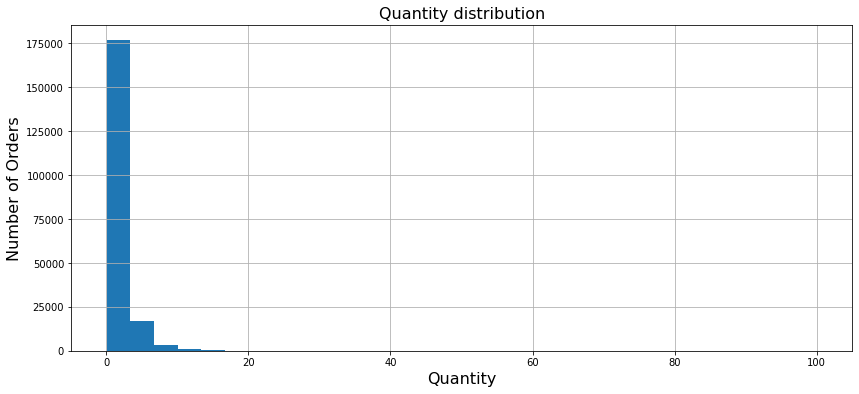

In [20]:
# Quantity distribution
_, ax = plt.subplots(figsize=(14, 6))
order_products.hist('quantity', bins=30, ax=ax)
plt.xlabel('Quantity', size=16)
plt.ylabel('Number of Orders', size=16)
plt.title('Quantity distribution', size=16)
plt.show()

**Observations:**
- we know that the total orders are 10,000 but there are only 9,978 orders in this order_products dataset
- 75% of the orders have a *quantity* up to 2, but we can see that we have some outliers with up to a *quantity* of 100
- *quantity* is right skewed
- since we have too many *product_id*, we can create new features to substitute it, such as the number of products in the order
- likewise we can use the *quantity* and *unit* to get the weight of the order

### 2.3 Shoppers

Knowing who's going to shop in each order is crucial, since every shopper has it's own characteristics.  
These characteristics are in the shopper's dataset.

In [21]:
# Load the dataset
shoppers = pd.read_csv(f'{DATASETS_PATH}/shoppers.csv')
shoppers.head()

,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,41dc7c9e385c4d2b6c1f7836973951bf,0.8606,1.94,1.00,4.87
1,e1c679ac73a69c01981fdd3c5ab8beda,6c90661e6d2c7579f5ce337c3391dbb9,0.8446,1.23,0.92,4.92
2,09d369c66ca86ebeffacb133410c5ee1,6c90661e6d2c7579f5ce337c3391dbb9,0.8559,1.56,1.00,4.88
3,db39866e62b95bb04ebb1e470f2d1347,50e13ee63f086c2fe84229348bc91b5b,NaN,2.41,NaN,NaN
4,8efbc238660053b19f00ca431144fdae,6c90661e6d2c7579f5ce337c3391dbb9,0.8770,1.31,0.92,4.88


In [22]:
# Dataset shape
print(f'shoppers shape: {shoppers.shape}')

shoppers shape: (2864, 6)


In [23]:
# Features and types
shoppers.dtypes

shopper_id        object
seniority         object
found_rate       float64
picking_speed    float64
accepted_rate    float64
rating           float64
dtype: object

In [24]:
# Check for missing or null values
print(f'number of missing values: {shoppers.isna().sum().sum()}')

number of missing values: 212


In [25]:
# Locating the missing values
shoppers.isna().sum()

shopper_id         0
seniority          0
found_rate       101
picking_speed      0
accepted_rate     27
rating            84
dtype: int64

In [26]:
# Dataset statistics
shoppers.describe()

,found_rate,picking_speed,accepted_rate,rating
count,2763.000000,2864.000000,2837.000000,2780.000000
mean,0.861082,1.762392,0.908276,4.848428
std,0.031038,0.665962,0.107911,0.133011
min,0.737300,0.650000,0.240000,3.880000
25%,0.842900,1.290000,0.880000,4.800000
50%,0.863900,1.580000,0.944444,4.880000
75%,0.881950,2.120000,1.000000,4.960000
max,0.971000,7.040000,1.000000,5.000000


In [27]:
# Number of unique values
shoppers.nunique()

shopper_id       2864
seniority           4
found_rate       1080
picking_speed     300
accepted_rate      92
rating             57
dtype: int64

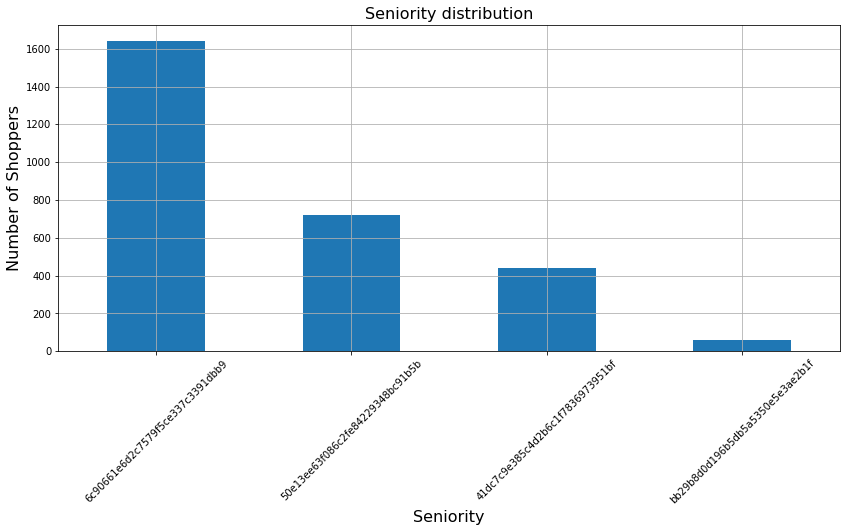

In [28]:
# Seniority distribution
_, ax = plt.subplots(figsize=(14, 6))
shoppers['seniority'].value_counts().plot(kind='bar', ax=ax)
plt.xlabel('Seniority', size=16)
plt.ylabel('Number of Shoppers', size=16)
plt.title('Seniority distribution', size=16)
plt.xticks(rotation=45)
plt.grid()
plt.show()

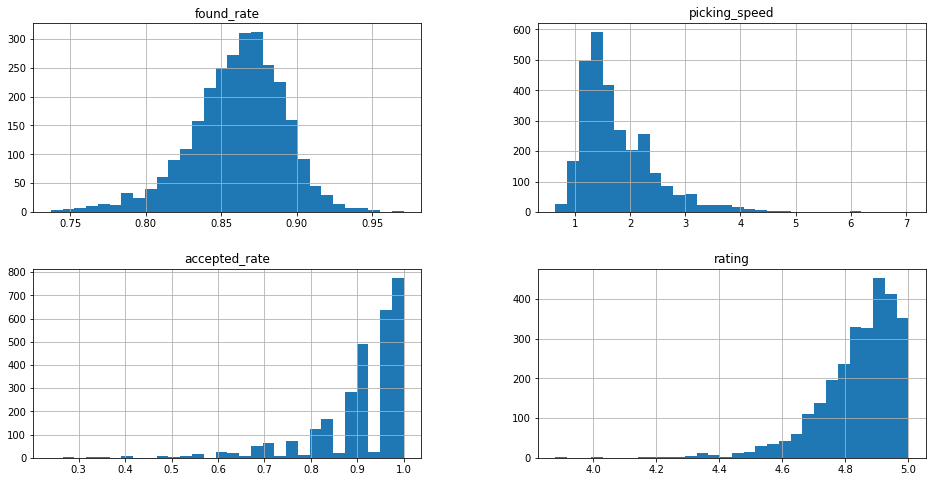

In [29]:
# Numerical features distribution
i, j = 0, 0
_, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
for feature in ['found_rate', 'picking_speed', 'accepted_rate', 'rating']:
    shoppers.hist(feature, bins=30, ax=ax[i, j])
    ax[i, j].grid(True)
    i = i + 1 if j == 1 else i
    j = 1 if j == 0 else 0
plt.show()

**Observations:**
- I don't know exactly how *accepted_rate* can affect the delivery time
- there are shoppers with missing values
- there are some outliers with respect to *picking_speed*, *accepted_rate* and *rating*
- *found_rate* seems to have a gaussian distribution
- *picking_speed*, *accepted_rate* and *rating* have skewness

### 2.4 Stores

Finally, the last dataset contains some information of the store branches.

In [30]:
# Load the dataset
store_branch = pd.read_csv(f'{DATASETS_PATH}/store_branch.csv')
store_branch.head()

,store_branch_id,store_id,lat,lng
0,aff1621254f7c1be92f64550478c56e6,92cc227532d17e56e07902b254dfad10,-33.422497,-70.609231
1,56352739f59643540a3a6e16985f62c7,0336dcbab05b9d5ad24f4333c7658a0e,-33.385484,-70.555579
2,7d04bbbe5494ae9d2f5a76aa1c00fa2f,9bf31c7ff062936a96d3c8bd1f8f2ff3,-33.416579,-70.565224
3,2b24d495052a8ce66358eb576b8912c8,c4ca4238a0b923820dcc509a6f75849b,-33.512578,-70.655952
4,5487315b1286f907165907aa8fc96619,d82c8d1619ad8176d665453cfb2e55f0,-33.347645,-70.542229


In [31]:
# Dataset shape
print(f'store_branch shape: {store_branch.shape}')

store_branch shape: (476, 4)


In [32]:
# Features and types
store_branch.dtypes

store_branch_id     object
store_id            object
lat                float64
lng                float64
dtype: object

In [33]:
# Check for missing or null values
print(f'number of missing values: {store_branch.isna().sum().sum()}')

number of missing values: 0


In [34]:
# Dataset statistics
store_branch.describe()

,lat,lng
count,476.000000,476.000000
mean,-33.457661,-70.737432
std,0.762492,0.513308
min,-36.904347,-73.096660
25%,-33.431260,-70.611515
50%,-33.401876,-70.577312
75%,-33.359701,-70.544190
max,-29.901425,-70.492256


In [35]:
# Number of unique values
store_branch.nunique()

store_branch_id    476
store_id           221
lat                445
lng                444
dtype: int64

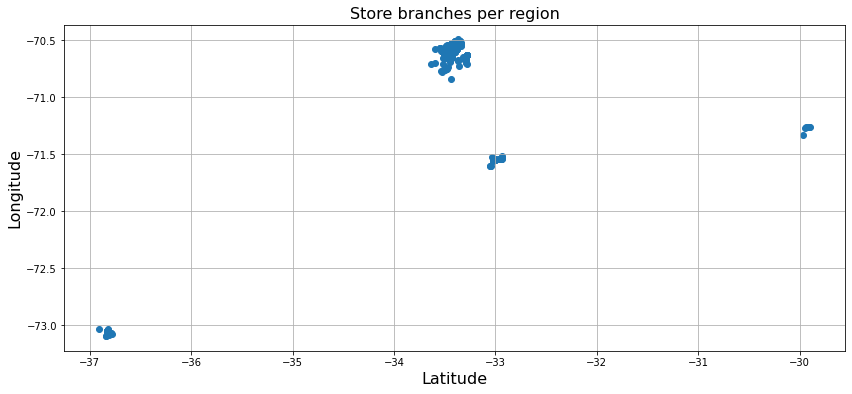

In [36]:
# Stores branches per region
plt.figure(figsize=(14, 6))
plt.scatter(store_branch['lat'], store_branch['lng'])
plt.grid()
plt.xlabel('Latitude', size=16)
plt.ylabel('Longitude', size=16)
plt.title('Store branches per region', size=16)
plt.show()

**Observations:**
- I don't see how *store_id* can be useful for our problem
- since we have the location of the customer and the store, we can create a feature with the distance between them

## 3 Data Manipulation

In this section we prepare our data so our model can handle it better.

In [37]:
# Compute period
orders_processed = orders.copy()
promised_time = orders_processed.pop('promised_time')
promised_time = pd.to_datetime(promised_time)
promised_hour = [item.hour for item in promised_time]
promised_period = []
for value in promised_hour:
    if value < 12:
        period = 'morning'
    elif value >= 12 and value < 18:
        period = 'afternoon'
    elif value >= 18:
        period = 'evening'
    promised_period.append(period)
orders_processed['promised_period'] = promised_period

In [38]:
# Preprocess order_products
order_products_processed = pd.DataFrame()
for order_id in order_products['order_id'].unique():
    order = order_products[order_products['order_id'] == order_id]
    units = order[order['buy_unit'] == 'UN']
    kg = order[order['buy_unit'] == 'KG']
    order_products_processed = order_products_processed.append({
        'order_id': order_id,
        'n_items': units['quantity'].sum(),
        'n_kg': kg['quantity'].sum()
    }, ignore_index=True)

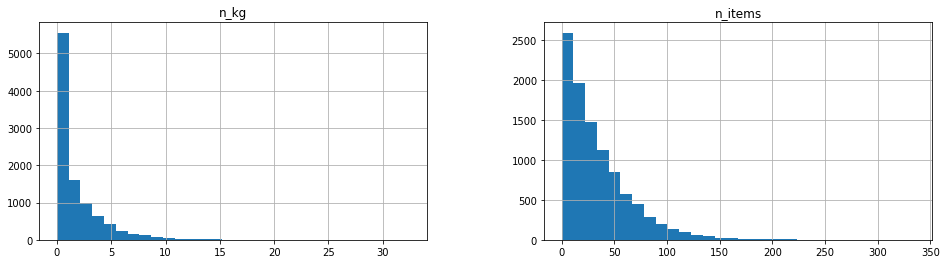

In [39]:
# KG and UN distribution
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
for i, feature in enumerate(['n_kg', 'n_items']):
    order_products_processed.hist(feature, bins=30, ax=ax[i])
    ax[i].grid(True)
plt.show()

In [40]:
# Preprocess shoppers
shoppers_processed = shoppers.copy()

# Rename seniorities
MAP = {
    '41dc7c9e385c4d2b6c1f7836973951bf': 'A',
    '6c90661e6d2c7579f5ce337c3391dbb9': 'B',
    '50e13ee63f086c2fe84229348bc91b5b': 'C',
    'bb29b8d0d196b5db5a5350e5e3ae2b1f': 'D'
}
shoppers_processed['seniority'] = shoppers_processed['seniority'].replace(MAP)

# Handle missing values
shoppers_processed = shoppers_processed.fillna(shoppers_processed.mean())

In [41]:
# Merge datasets
dataframe = pd.merge(orders_processed, order_products_processed, on='order_id')
dataframe = pd.merge(dataframe, shoppers_processed, on='shopper_id')
dataframe = pd.merge(dataframe, store_branch, on='store_branch_id')
dataframe.head()

,order_id,lat_x,lng_x,on_demand,shopper_id,store_branch_id,total_minutes,promised_period,n_items,n_kg,seniority,found_rate,picking_speed,accepted_rate,rating,store_id,lat_y,lng_y
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,evening,16.0,2.756,B,0.9024,1.30,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925
1,3bb5d9adb3ecac1925b60d5d26a510c4,-33.491167,-70.571649,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,160.336211,afternoon,63.0,2.900,B,0.9024,1.30,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925
2,b838eea64cf24dde0a78ce1feb84ca7c,-33.493406,-70.594164,False,cb5ef07d15fb3981eeb6e0011bc80163,65ded5353c5ee48d0b7d48c591b8f430,122.239210,afternoon,155.0,1.000,B,0.8909,1.17,0.96,5.00,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925
3,2c85303190a77493348b0b827232f4d6,-33.487836,-70.572412,False,ca54a789a8dc54742710490e25df9844,65ded5353c5ee48d0b7d48c591b8f430,133.113926,evening,115.0,7.646,B,0.8462,1.11,0.96,4.96,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925
4,e606cc26b843c312df82a29d1f8d4372,-33.504759,-70.552168,False,362e274d254be8fae76396b8f10a7fd5,65ded5353c5ee48d0b7d48c591b8f430,94.734479,morning,97.0,2.216,C,0.8138,1.89,0.84,4.68,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925


In [42]:
# Compute distances
distances = []
for _, row in dataframe.iterrows():
    point_1 = row[['lat_x', 'lng_x']].values.reshape(1, -1)
    point_2 = row[['lat_y', 'lng_y']].values.reshape(1, -1)
    distance = manhattan_distances(point_1, point_2)
    distances.append(distance[0][0])
dataframe['distance'] = distances
dataframe = dataframe.drop(['lat_x', 'lng_x', 'lat_y', 'lng_y'], axis=1)

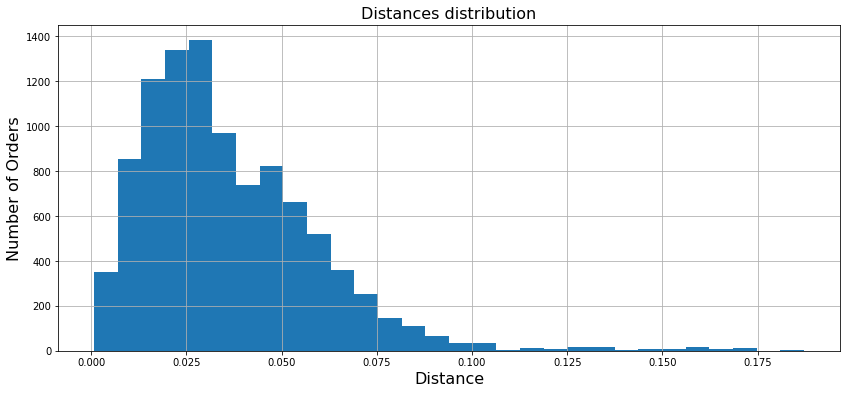

In [43]:
# Distance distribution
_, ax = plt.subplots(figsize=(14, 6))
dataframe.hist('distance', bins=30, ax=ax)
plt.xlabel('Distance', size=16)
plt.ylabel('Number of Orders', size=16)
plt.title('Distances distribution', size=16)
plt.show()

In [44]:
# Drop features
order_ids = dataframe[['order_id']]
dataframe = dataframe.drop(['order_id', 'shopper_id', 'store_branch_id', 'store_id'], axis=1)

In [45]:
# Convert to numerical features
dataframe['on_demand'] = dataframe['on_demand'].replace({False: 0, True: 1})

for feature in ['promised_period', 'seniority']:
    column = dataframe.pop(feature)
    new_columns = pd.get_dummies(column, prefix=feature)
    dataframe = pd.concat([dataframe, new_columns], axis=1)

**Observations:**
- since I intend to use a linear model (for simplicity), I prefer to compute *promised_period* instead of using *promised_time*
- *product_id*, *quantity* and *buy_unit* were replaced by *n_items* and *n_kg* per order
- rename seniorities just to make it more readable
- replace missing values with the feature mean
- create *distance* from store branch and delivery location
- *distance* is right skewed

## 4 Predictive Modeling

Now it's time to start modeling the data to estimate the delivery time.

In [46]:
# Split dataset
x = dataframe.drop('total_minutes', axis=1)
y = dataframe['total_minutes']

x_submission = x[y.isna()]
y_submission = order_ids[y.isna()]
x = x[~y.isna()]
y = y[~y.isna()]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
print(f'train size: {len(x_train)}')
print(f'test size: {len(x_test)}')

train size: 6386
test size: 1597


In [47]:
# Scale dataset
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
x_test_norm = scaler.transform(x_test)
x_submission_norm = scaler.transform(x_submission)
y_train = y_train.values
y_test = y_test.values

In [48]:
# Significance level between train and test
_, p_value = ttest_ind(x_train_norm, x_test_norm)
for i, feature in enumerate(x):
    print(f'{feature}: {p_value[i]}')

on_demand: 0.7352896239956106
n_items: 0.807346955056032
n_kg: 0.44391242173278245
found_rate: 0.4539999941720121
picking_speed: 0.2072676710405022
accepted_rate: 0.5861322873175899
rating: 0.6972962641535396
distance: 0.38652109645142074
promised_period_afternoon: 0.2018294572582607
promised_period_evening: 0.12803395057290523
promised_period_morning: 0.665330594209002
seniority_A: 0.6133341053172592
seniority_B: 0.23107739738452387
seniority_C: 0.05542576377468334
seniority_D: 0.7629494860614894


In [49]:
# Significance level between train and submission
_, p_value = ttest_ind(x_train_norm, x_submission_norm)
for i, feature in enumerate(x):
    print(f'{feature}: {p_value[i]}')

on_demand: 0.9383382421275477
n_items: 0.531078395095627
n_kg: 0.2499047968164315
found_rate: 0.5931074469560347
picking_speed: 0.4492592653935452
accepted_rate: 0.5507143497797794
rating: 0.02578384418715269
distance: 0.510690297652064
promised_period_afternoon: 0.7740969382283777
promised_period_evening: 0.9104318856001932
promised_period_morning: 0.8049555258493107
seniority_A: 0.8526398097085908
seniority_B: 0.3056370709886135
seniority_C: 0.5560141531866571
seniority_D: 0.08042505724645771


**Observations:**
- values without y value, are separated as the submission data
- the significance level between the samples tells us that the distribution is the same

### 4.1 Evaluation Metrics

Here we define the evaluation functions used to compare the models that we are going to create.
- **bayesian optimization**: is a sequential design strategy for global optimization of black-box functions
- **mean absolute error**: was chosen due to the ability to easly understand the error (in this case, in minutes)
- **business function**: this business function generates larger errors when the estimation time is less than the actual delivery time
- **shapiro wilk test**: is a test of normality

In [50]:
# Business scoring
def business_function(y, y_hat):
    y = y.reshape(1, -1)
    y_hat = y_hat.reshape(1, -1)
    mse = mean_absolute_error(y, y_hat, multioutput="raw_values")

    errors = (y - y_hat).reshape(-1, 1)
    mse = np.where(errors[:, 0] <= 0, mse * 0.5, mse)
    mse = np.where(errors[:, 0] > 0, mse * 2, mse)

    return mse.mean()

business_scoring = make_scorer(business_function, greater_is_better=False)

In [51]:
# Train function
def train(x, y):
    search = BayesSearchCV(
        Lasso(random_state=1),
        {
            'alpha': (1e-6, 1e+6, 'log-uniform')
        },
        scoring=business_scoring,
        cv=3,
        n_iter=20,
        return_train_score=True,
        random_state=1
    )
    search.fit(x, y)

    best_index = search.best_index_
    results = {
        'train_score': -1 * search.cv_results_['mean_train_score'][best_index],
        'validation_score': -1 * search.cv_results_['mean_test_score'][best_index],
        'model': search.best_estimator_
    }

    return results

In [52]:
# Predict function
def predict(x, model):
    y_hat = model.predict(x)
    return y_hat

In [53]:
# Evaluation function
def evaluate(y, y_hat):

    # compute mse
    y = y.reshape(1, -1)
    y_hat = y_hat.reshape(1, -1)
    errors = (y - y_hat).reshape(-1, 1)
    mse = mean_absolute_error(y, y_hat, multioutput="raw_values")
    mse = np.where(errors[:, 0] <= 0, mse * 0.5, mse)
    mse = np.where(errors[:, 0] > 0, mse * 2, mse)
    score = mse.mean()

    # statistical test
    errors_norm = StandardScaler().fit_transform(errors)
    _, p_value = shapiro(errors_norm)
    
    # print
    total_size = len(errors)
    before_time = (errors <= 0).sum() / total_size
    before_15_minutes = ((errors <= 0) & (errors > -15)).sum() / total_size
    after_time = (errors > 0).sum() / total_size
    after_15_minutes = ((errors > 0) & (errors < 15)).sum() / total_size
    print(f'before_time: {before_time}')
    print(f'before_15_minutes: {before_15_minutes}')
    print(f'after_time: {after_time}')
    print(f'after_15_minutes: {after_15_minutes}')

    # plot
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

    ax[0].scatter(y[0, :], errors)
    ax[0].set_xlabel('Expected Value', size=16)
    ax[0].set_ylabel('Absolute Error', size=16)
    ax[0].set_title(f'MAE = {score}', size=16)
    ax[0].grid()

    ax[1].hist(errors_norm[:, 0], bins=100)
    ax[1].set_xlabel('Normalized Error', size=16)
    ax[1].set_ylabel('Count', size=16)
    ax[1].set_title(f'p-value = {p_value}', size=16)
    ax[1].grid()

### 4.2 Introducing Lasso

Lasso Regression is a type of linear regression that uses shrinkage. Shrinkage is where data values are shrunk towards a central point, like the mean. The lasso procedure encourages simple, sparse models (i.e. models with fewer parameters).

It was chosen in this project because it is simple and has few parameters to be optimized.

In [54]:
# Train
results = train(x_train_norm, y_train)
print(f'train score: {results["train_score"]}')
print(f'validation score: {results["validation_score"]}')

train score: 25.863459992498445
validation score: 25.924074893070756


before_time: 0.5718759787034137
before_15_minutes: 0.2571249608518634
after_time: 0.4281240212965863
after_15_minutes: 0.18430942687128093


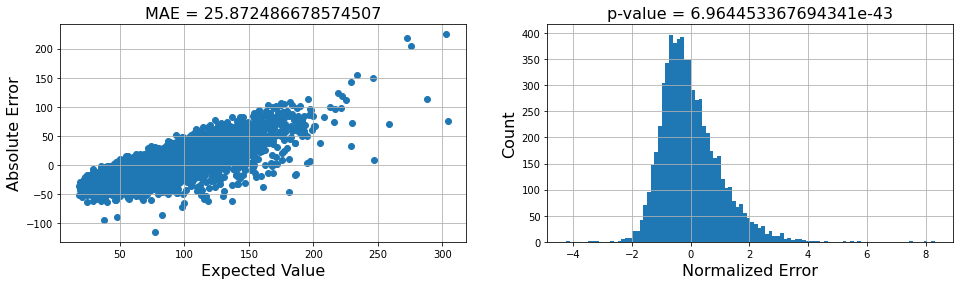

In [55]:
# Evaluate
y_hat = predict(x_train_norm, results['model'])
evaluate(y_train, y_hat)

**Observations:**
- the model couldn't give good predictions for high values
- some causes may be: non-linear correlations, colinearity, outliers and non-gaussian features

### 4.3 Polynomial Features

To increase our model's complexity, with the goal of capturing non-linearity, we can manually create polynomial features.

In [56]:
# Create features
polynomial = PolynomialFeatures(degree=2)
polynomial.fit(x_train_norm)
x_train_poly = polynomial.transform(x_train_norm)
x_test_poly = polynomial.transform(x_test_norm)
x_submission_poly = polynomial.transform(x_submission_norm)
print(f'new shape: {x_train_poly.shape}')

new shape: (6386, 136)


In [57]:
# Train
results = train(x_train_poly, y_train)
print(f'train score: {results["train_score"]}')
print(f'validation score: {results["validation_score"]}')

train score: 24.686746169330277
validation score: 25.150767181925225


before_time: 0.577983088005011
before_15_minutes: 0.27341058565612275
after_time: 0.42201691199498903
after_15_minutes: 0.18446601941747573


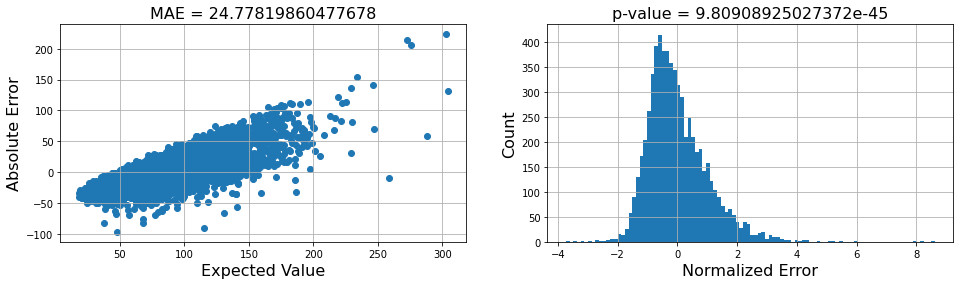

In [58]:
# Evaluate
y_hat = predict(x_train_poly, results['model'])
evaluate(y_train, y_hat)

**Observations:**
- MSE was reduced by adding polynomial features with degree up to 2

### 4.4 Feature Engineering

Let's use logarithm function to reduce features skewness.

In [59]:
# Apply logarithm function
x_train_engineering = x_train.copy()
x_test_engineering = x_test.copy()
x_submission_engineering = x_submission.copy()
for feature in ['n_kg', 'n_items', 'picking_speed', 'accepted_rate', 'rating', 'distance']:
    x_train_engineering[feature] = np.log1p(x_train_engineering[feature])
    x_test_engineering[feature] = np.log1p(x_test_engineering[feature])
    x_submission_engineering[feature] = np.log1p(x_submission_engineering[feature])

In [60]:
# Scale dataset
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train_engineering)
x_test_norm = scaler.transform(x_test_engineering)
x_submission_norm = scaler.transform(x_submission_engineering)

In [61]:
# Create polynomial features
polynomial = PolynomialFeatures(degree=2)
polynomial.fit(x_train_norm)
x_train_poly = polynomial.transform(x_train_norm)
x_test_poly = polynomial.transform(x_test_norm)
x_submission_poly = polynomial.transform(x_submission_norm)

In [62]:
# Train
results = train(x_train_poly, y_train)
print(f'train score: {results["train_score"]}')
print(f'validation score: {results["validation_score"]}')

train score: 24.443110263293864
validation score: 24.850888615885214


before_time: 0.5782962730974006
before_15_minutes: 0.2815533980582524
after_time: 0.42170372690259944
after_15_minutes: 0.18571875978703414


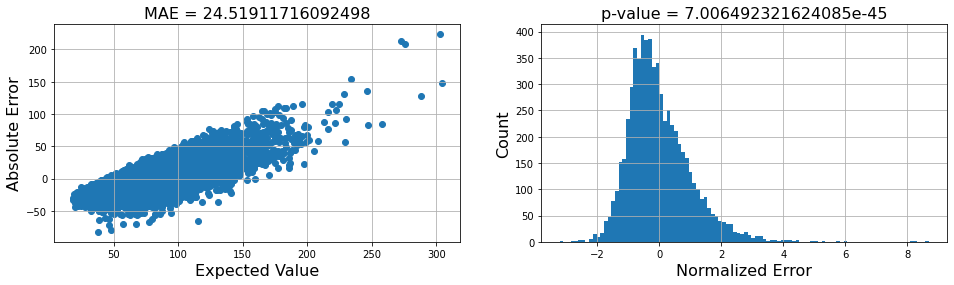

In [63]:
# Evaluate
y_hat = predict(x_train_poly, results['model'])
evaluate(y_train, y_hat)

**Observations:**
- MSE reduced by reducing features skewness

### 4.5 Tackling Outliers

Models can be heavily affected by outliers. One way of dealing with them is simply removing these samples.

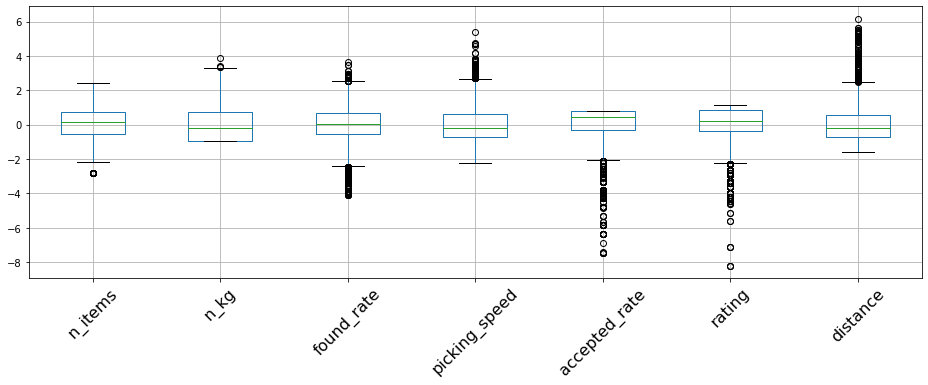

In [64]:
# Box plots
NUMERIC_FEATURES = ['n_items', 'n_kg', 'found_rate', 'picking_speed', 'accepted_rate', 'rating', 'distance']
x_box_plot = pd.DataFrame(x_train_norm, columns=x_train_engineering.columns)
plt.figure(figsize=(16, 5))
x_box_plot[NUMERIC_FEATURES].boxplot()
plt.xticks(rotation=45, size=16)
plt.show()

In [65]:
# Remove outliers
initial_length = len(x_train_norm)
x_train_outlier = pd.DataFrame(x_train_norm, columns=x_train.columns)
y_train_outlier = pd.DataFrame(y_train)

for feature in NUMERIC_FEATURES:
    values = x_train_outlier[feature]
    upper_limit = np.quantile(values, 0.75) + 1.5 * iqr(values)
    lower_limit = np.quantile(values, 0.25) - 1.5 * iqr(values)
    conditional = (values < upper_limit) & (values > lower_limit)
    x_train_outlier = x_train_outlier[conditional]
    y_train_outlier = y_train_outlier[conditional]

print(f'number of outliers: {initial_length - len(x_train_outlier)}')

number of outliers: 912


In [66]:
# New dataset shape
print(f'new dataset shape: {x_train_outlier.shape}')

new dataset shape: (5474, 15)


In [67]:
# Scale dataset
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train_outlier)
x_test_norm = scaler.transform(x_test_norm)
x_submission_norm = scaler.transform(x_submission_norm)
y_train = y_train_outlier.values

In [68]:
# Create polynomial features
polynomial = PolynomialFeatures(degree=2)
polynomial.fit(x_train_norm)
x_train_poly = polynomial.transform(x_train_norm)
x_test_poly = polynomial.transform(x_test_norm)
x_submission_poly = polynomial.transform(x_submission_norm)

In [69]:
# Train
results = train(x_train_poly, y_train)
print(f'train score: {results["train_score"]}')
print(f'validation score: {results["validation_score"]}')

train score: 23.91125773624566
validation score: 24.389591155576127


before_time: 0.571611253196931
before_15_minutes: 0.2774936061381074
after_time: 0.42838874680306904
after_15_minutes: 0.19108512970405553


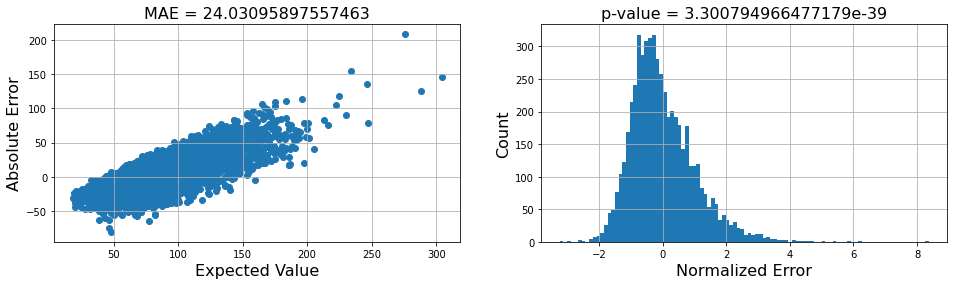

In [70]:
# Evaluate
y_hat = predict(x_train_poly, results['model'])
evaluate(y_train, y_hat)

**Observations:**
- MSE improved by removing outliers

### 4.6 Colinearity

Our model still strugles to estimate high values.  
In this section, I'll look for colinear features to mitigate coeficients instability in the model.

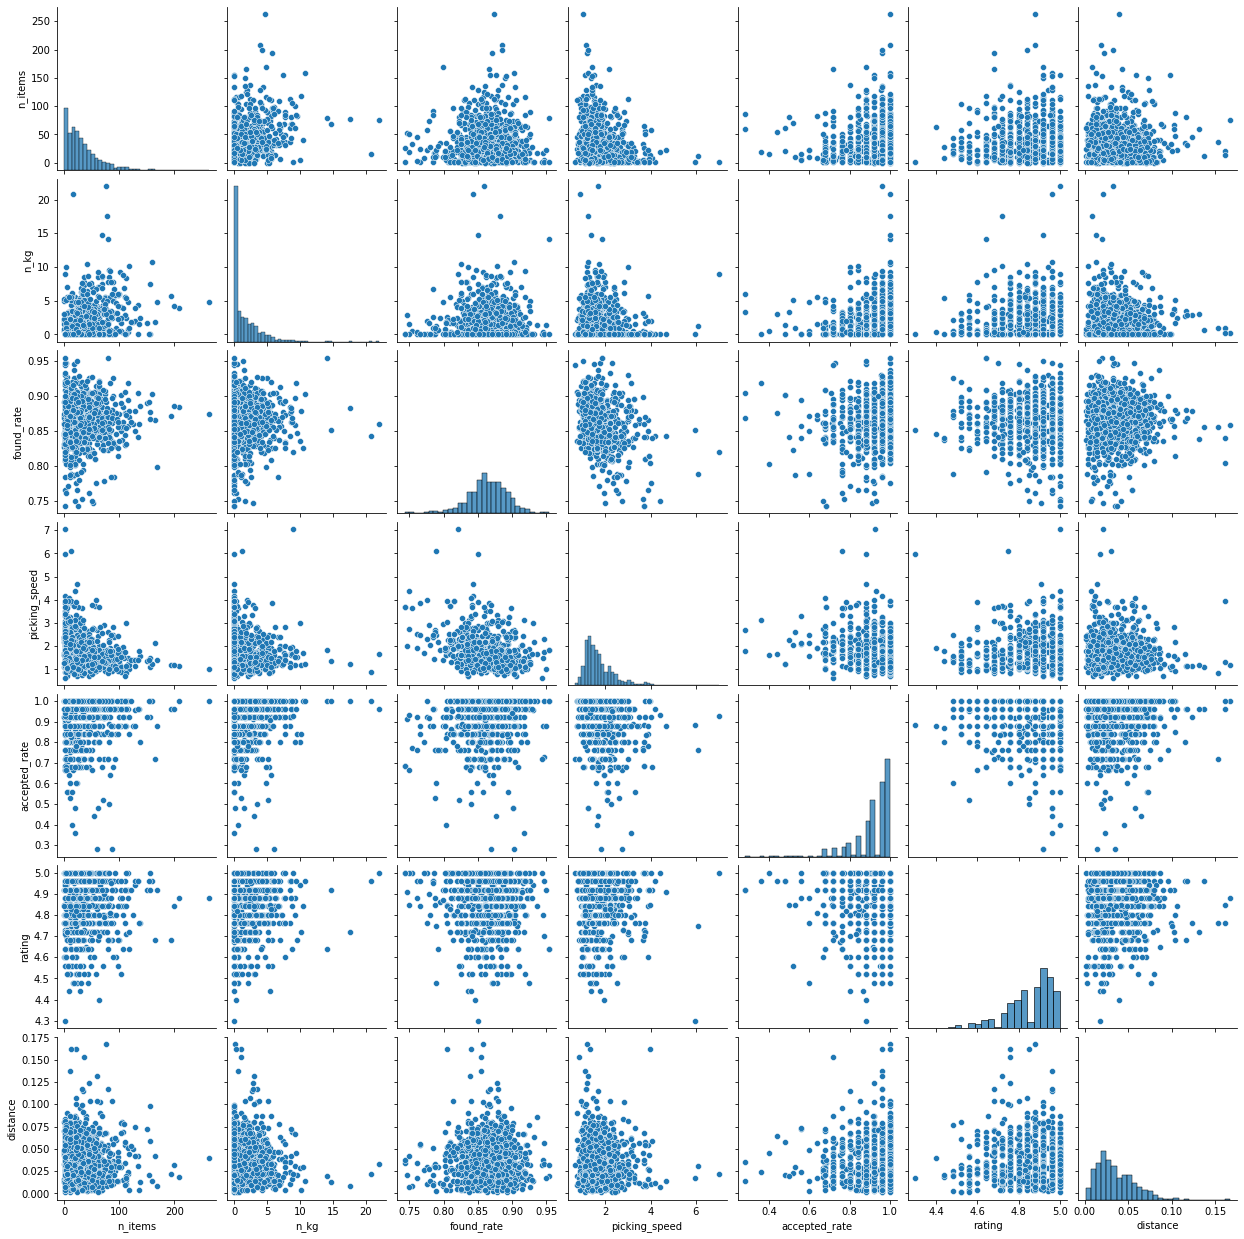

In [71]:
# Plot relationships
FEATURES = ['n_items', 'n_kg', 'found_rate', 'picking_speed', 'accepted_rate', 'rating', 'distance']
sns.pairplot(x_train[FEATURES].iloc[0:1000])

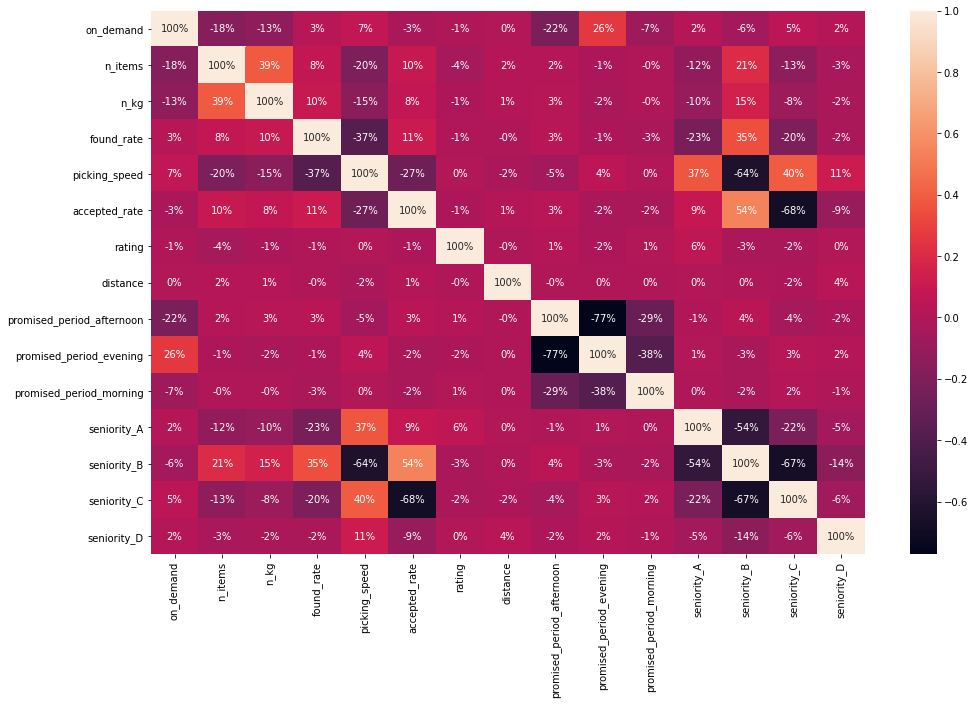

In [72]:
# Pearson's correlation
plt.figure(figsize=(16, 10))
_ = sns.heatmap(x_train.corr(), annot=True, fmt=".0%")

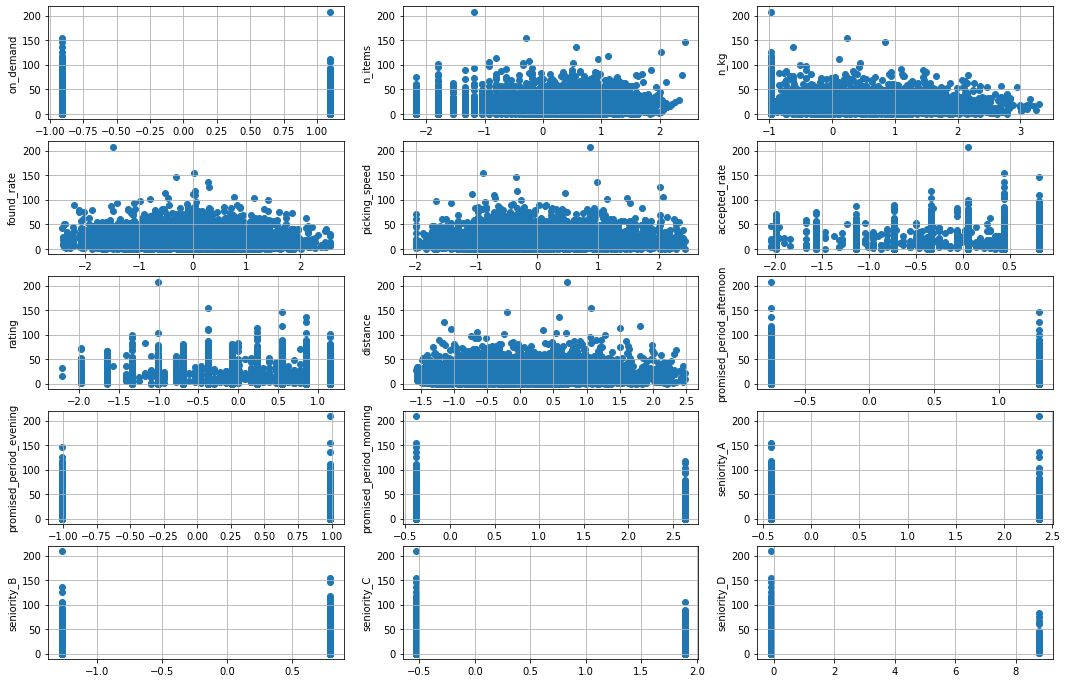

In [73]:
# Errors by feature
y_hat = predict(x_train_poly, results['model'])
mse = mean_absolute_error(y_train.reshape(1, -1), y_hat.reshape(1, -1), multioutput="raw_values")

i, j = 0, 0
_, ax = plt.subplots(nrows=5, ncols=3, figsize=(18, 12))
for feature in x_train_outlier.columns:
    ax[i, j].scatter(x_train_outlier[feature], mse)
    ax[i, j].set_ylabel(feature)
    ax[i, j].grid(True)
    i = i + 1 if j == 2 else i
    j = j + 1 if j != 2 else 0
plt.show()

**Observations:**
- I don't see much to be done here, since there's no high correlations

### 4.7 Results

Previously, we separated some samples to be used as test. Here we can see how our model will perform in real unseen data.

before_time: 0.5641828428303068
before_15_minutes: 0.2667501565435191
after_time: 0.43581715716969316
after_15_minutes: 0.20225422667501566


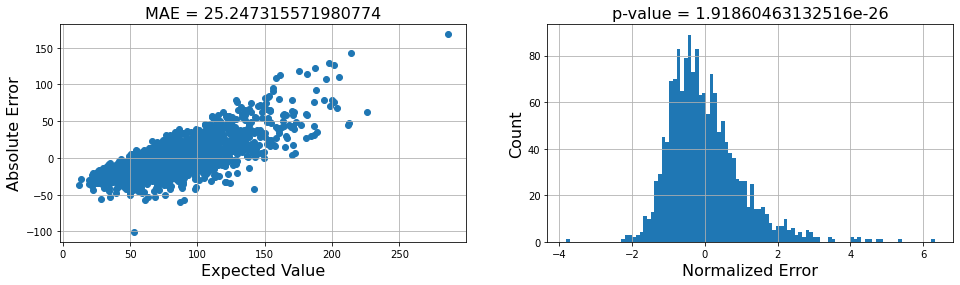

In [74]:
# Test
y_hat = predict(x_test_poly, results['model'])
evaluate(y_test, y_hat)

In [75]:
# Save submission predictions
y_hat = predict(x_submission_poly, results['model'])
y_submission['total_minutes'] = y_hat
y_submission.to_csv('submission/submission.csv')

## 5 Conclusions

With the test results we can expect from our model a mean absolute error of 25 minutes in real delivery time estimation.  
It is possible to see how the model get relative good results when the prediction time is below 100 minutes.  
This is probably due to the our model not be strong enought to handle non-linearities.  

Also, it is possible to expect that 56.4% of the orders are going to be delivered in less time than the estimated.  
And, only 23.4% of the orders will be delivered with more than 15 minutes of delay.

I believe we got good results for a first evaluation.

**For future work:**
- use more complex models, such as random forest or other ensemble techniques
- gather more features, such as the traffic between the store and the user address